In [66]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import scipy.interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path
from scipy.optimize import curve_fit
import scipy.interpolate
import pandas as pd 

plt.rcParams.update({'font.size': 12})
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rc('text', usetex=True)


In [67]:
#thresholds 
kk=0.19396
kkk=0.29232
kkpi=0.26302
kketa=0.29760
kksigma=0.32556
kkpipi=0.33208
kkomega=0.34937
kketaprime=0.35806
kkpieta=0.36667
kkphi=0.37345
kkkk=0.38792

In [70]:

def spectrum_plotter(irrep):
    plt.rcParams.update({'font.size': 12})
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    #plt.rc('font',**{'family':'serif','serif':['Palatino']})
    plt.rc('text', usetex=True)

    spectrum_file1 = "spectrum/spectrum.L20." + str(irrep)
    spectrum_file2 = "spectrum/spectrum.L24." + str(irrep)
    non_int_file = "non_int." + str(irrep)
    title = non_int_file.split(".")

    non_int_list = np.genfromtxt(non_int_file,unpack=True)
    L1, E1, Eerr1 = np.genfromtxt(spectrum_file1,unpack=True)
    L2, E2, Eerr2 = np.genfromtxt(spectrum_file2,unpack=True)

    print(len(non_int_list))

    fig, ax = plt.subplots(figsize = (5,10))
    ax.set_title(title[1],fontsize=22)
    ax.set_xlim([non_int_list[0].min(),non_int_list[0].max()])
    ax.set_ylim([0.15,0.31])
    ax.set_xticks([20, 22, 24], ['20', ' ', '24'])
    #ax.set_yticks(np.arange(0.15, 0.31, step=0.09))
    ax.set_yticks([0.15, kk, 0.24, kkpi, 0.31], ['0.15', '$KK$', '0.24', '$KK\pi$', '0.31'])
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.axhline(y = kk, color = 'grey', linestyle = '--',linewidth=1)
    ax.axhline(y = kkpi, color = 'grey', linestyle = '--',linewidth=1)
    #ax.axvline(x = 0.0, color = 'black', linestyle = '-',linewidth=1)
    for i in range(len(non_int_list)-1):
        xval = non_int_list[0]
        yval = non_int_list[i+1]
        ax.plot(xval,yval,linestyle='-',color='black')        
    ax.errorbar(L1, E1 , xerr=None, yerr=Eerr1,
                marker='o',markerfacecolor="None", markersize=10, color="black",
                linestyle='none',capsize=5)
    ax.errorbar(L2, E2 , xerr=None, yerr=Eerr2,
                marker='o',markerfacecolor="None", markersize=10, color="black",
                linestyle='none',capsize=5)

    fig.tight_layout()
    output_file = "spectrum_plot." + str(irrep) + ".pdf"
    
    plt.savefig(output_file)
    plt.draw()
    #plt.close()

4
5
6
3
5


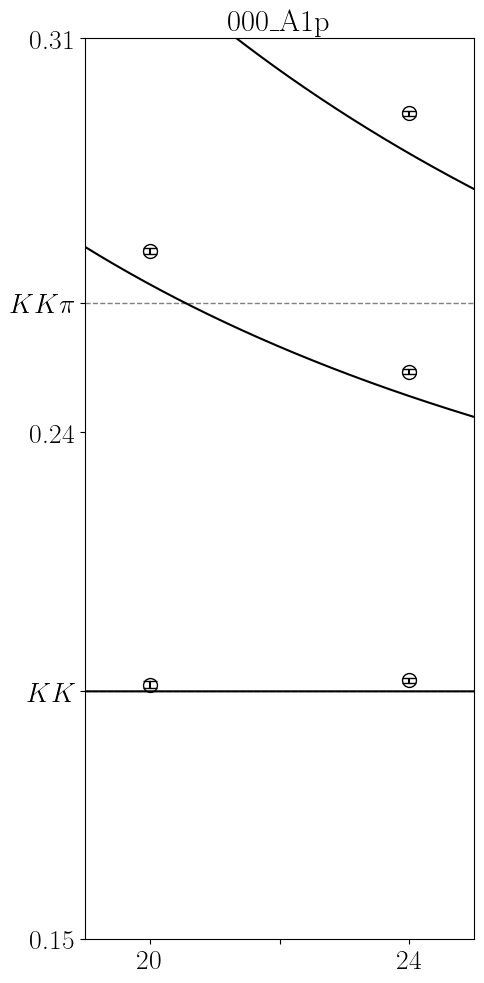

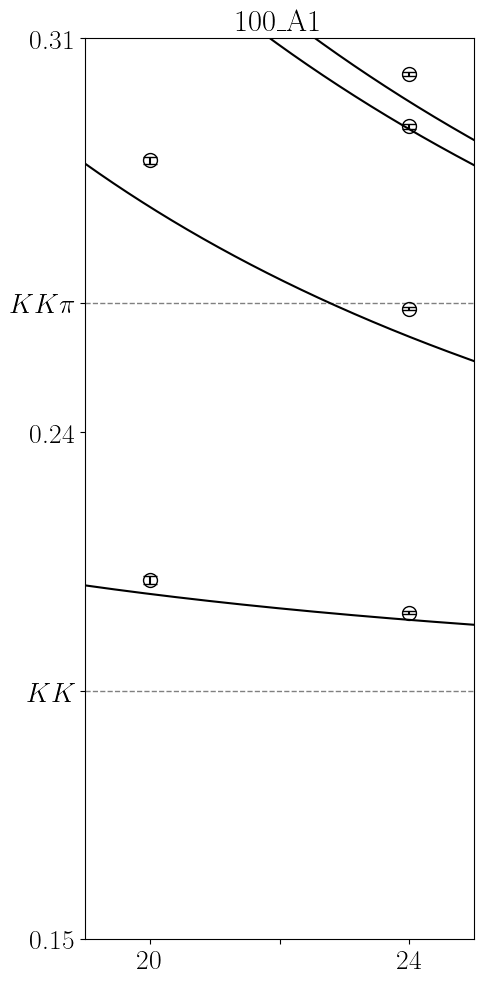

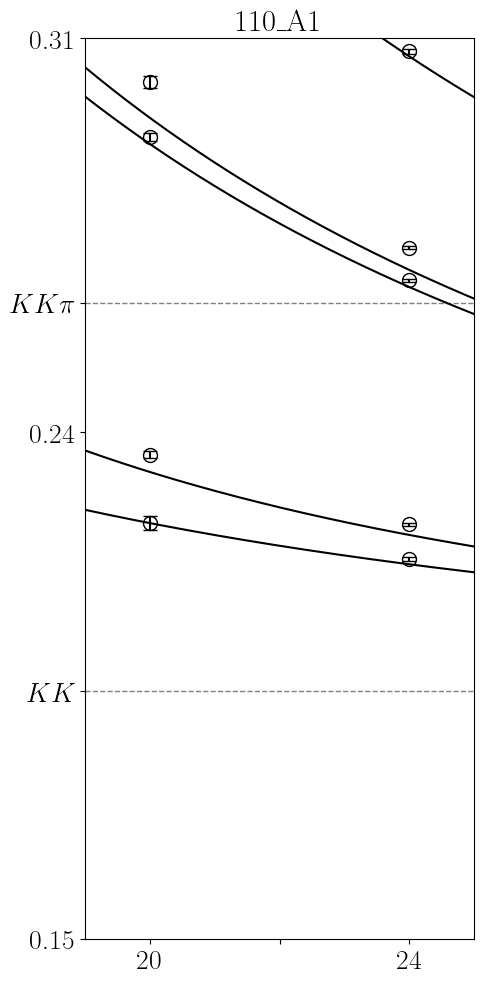

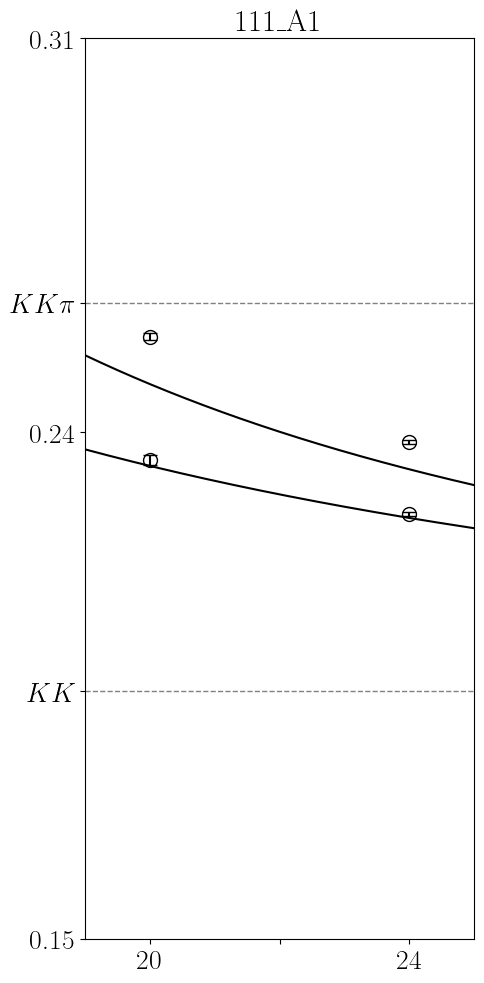

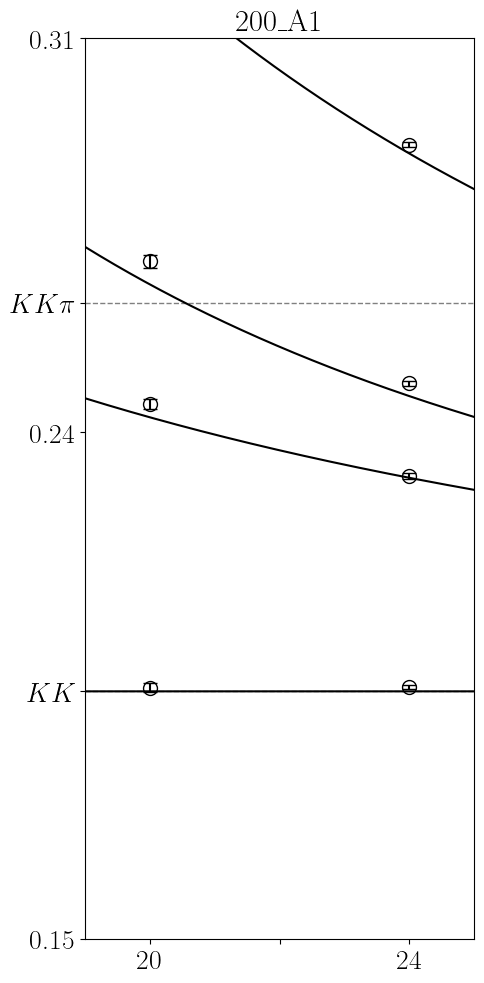

In [71]:
spectrum_plotter("000_A1p")
spectrum_plotter("100_A1")
spectrum_plotter("110_A1")
spectrum_plotter("111_A1")
spectrum_plotter("200_A1")

In [32]:
def config_maker( max_nsq ):
    nx = []
    ny = []
    nz = []

    count = 1
    for i in range(-max_nsq,max_nsq+1,1):
        for j in range(-max_nsq,max_nsq+1,1):
            for k in range(-max_nsq,max_nsq+1,1):
                config_sq = i*i + j*j + k*k 
                if(config_sq<=max_nsq):
                    print("config ",count,": ",i,j,k)
                    count = count + 1 
                    nx.append(i)
                    ny.append(j)
                    nz.append(k)
                else:
                    continue
        
    return nx,ny,nz 


def energy( atm, 
            xi, 
            Lbyas,
            nx,
            ny,
            nz  ):
    onebyxi = 1.0/xi 
    pi = np.pi
    twopibyLbyas = 2.0*pi/Lbyas 
    nsquare = nx*nx + ny*ny + nz*nz 

    return np.sqrt(atm*atm + onebyxi*onebyxi*twopibyLbyas*twopibyLbyas*nsquare)


def irrep_list_maker(energy_file):
    df = pd.read_csv(energy_file,delim_whitespace=True, header=None)
    dflist = df.values.tolist()
    irrep_list = []
    for i in range(len(dflist)):
        irrep = dflist[i][1]
    
        if len(irrep_list)==0:
            irrep_list.append(irrep)
        else:
            check_irrep_list_flag = 0
            for j in range(len(irrep_list)):
                temp_irrep = irrep_list[j]
            
                if(temp_irrep == irrep):
                    check_irrep_list_flag = 1
                    break 
            if(check_irrep_list_flag==0):
                irrep_list.append(irrep)

    return dflist, irrep_list 

def irrep_energy_list_maker(full_energy_list, fixed_irrep):
    Ecm_list = []
    Elat_list = []

    for i in range(len(full_energy_list)):
        if(full_energy_list[i][1]==fixed_irrep):
            Ecm_list.append(float(full_energy_list[i][2]))
            Elat_list.append(float(full_energy_list[i][3]))

    return Ecm_list, Elat_list 

def canonical_mom_maker(nx, ny, nz):
    temp_list = []
    temp_list.append(abs(nx))
    temp_list.append(abs(ny))
    temp_list.append(abs(nz))
    temp_list.sort(reverse=True)
    
    return temp_list

def nonint_spectrum_maker(atm, xi, max_nsq, irrep, Lmin, Lmax, Lpoints, energy_file):
    
    #tolerance for energy matching 
    tolerance = 1.0e-3
    #we get the full channel.energies files and the unique irrep list 
    full_energy_list, irrep_list = irrep_list_maker(energy_file)
    Lbyas = int(full_energy_list[0][0])
    print("L = ",Lbyas)
    #irrep = irrep_list[5]
    print("irrep = ",irrep)

    #we create the momentum configurations possible for max n^2
    nx, ny, nz = config_maker(max_nsq)

    #we take the frame momentum from the irrep string 
    frame_mom_str = irrep.split("_")
    frame_n = []
    for i in frame_mom_str[0]:
        frame_n.append(int(i))
    config_num = len(nx)
    frame_nx = frame_n[0]
    frame_ny = frame_n[1]
    frame_nz = frame_n[2]


    #we calculate the momentum square of the frame 
    onebyxi = 1.0/xi 
    pi = np.pi
    twopibyLbyas = 2.0*pi/Lbyas 
    frame_nsquare = frame_nx*frame_nx + frame_ny*frame_ny + frame_nz*frame_nz 
    print("f sq = ",frame_nsquare)
    frame_momsq = onebyxi*onebyxi*twopibyLbyas*twopibyLbyas*frame_nsquare

    #list for selected config numbers
    selected_config_list1 = []
    selected_config_list2 = []
    irrep_Ecm_list, irrep_Elat_list = irrep_energy_list_maker(full_energy_list,irrep)
    completed_ecm = []

    for i in range(config_num):
        for j in range(config_num):
            particle1_energy = energy(atm,xi,Lbyas,frame_nx - nx[i],frame_ny - ny[i],frame_nz - nz[i])
            particle2_energy = energy(atm,xi,Lbyas,nx[j],ny[j],nz[j])

            E_lat = particle1_energy + particle2_energy

            Ecm = np.sqrt(E_lat*E_lat - frame_momsq)
            #print(Ecm)
            

            for k in range(len(irrep_Ecm_list)):
                irrep_en = irrep_Ecm_list[k]
                irrep_en_diff = abs(irrep_en - Ecm)
                check_completed_ecm_flag = 0
                if(irrep_en_diff<=tolerance):
                    if(len(completed_ecm)==0):
                        selected_config_list1.append(i)
                        selected_config_list2.append(j)
                        completed_ecm.append(irrep_en)
                        continue 
                    else:
                        for l in range(len(completed_ecm)):
                            diff_completed_ecm = abs(irrep_en - completed_ecm[l])

                            if(diff_completed_ecm<=tolerance):
                                check_completed_ecm_flag = 1
                    
                    if(check_completed_ecm_flag==0):
                        selected_config_list1.append(i)
                        selected_config_list2.append(j)
                        completed_ecm.append(irrep_en)

    print(irrep_Ecm_list)
    print(completed_ecm)
    print(selected_config_list1)
    print(selected_config_list2)
    out_file_list = np.zeros((len(selected_config_list1)+1,Lpoints)) 
    
    for i in range(len(selected_config_list1)):
        ind1 = selected_config_list1[i]
        ind2 = selected_config_list2[i]

        canonical_n_list1 = canonical_mom_maker(nx[ind1],ny[ind1],nz[ind1])
        
        canonical_n_list2 = canonical_mom_maker(nx[ind2],ny[ind2],nz[ind2]) 

        L = np.linspace(Lmin,Lmax,Lpoints)

        

        for l_ind in range(Lpoints):

            particle1_energy = energy(atm,xi,L[l_ind],frame_nx-nx[ind1],frame_ny-ny[ind1],frame_nz-nz[ind1])
            particle2_energy = energy(atm,xi,L[l_ind],nx[ind2],ny[ind2],nz[ind2])

            E_lat = particle1_energy + particle2_energy

            Ecm = np.sqrt(E_lat*E_lat - frame_momsq)

            out_file_list[0][l_ind] = L[l_ind] 
            out_file_list[i+1][l_ind] = Ecm 


    out_file = "non_int." + str(irrep) 
    f = open(out_file,'w')

    for i in range(len(out_file_list[0])):
        for j in range(len(out_file_list)):
            f.write(str(out_file_list[j][i]) + '\t')
            #print(out_file_list[i][j], sep=",")
        f.write('\n')
        #print("\n")        
        #print("p1:",canonical_n_list1[0],canonical_n_list1[1],canonical_n_list1[2],
        #      "p2:",canonical_n_list2[0],canonical_n_list2[1],canonical_n_list2[2])
    print(len(out_file_list))
    print(len(out_file_list[0]))
    f.close() 


In [62]:
def discrete_nonint_spectrum_maker(atm, xi, max_nsq, irrep, Lmin, Lmax, Lpoints, energy_file1, energy_file2):
    
    #tolerance for energy matching 
    tolerance = 1.0e-3
    #we get the full channel.energies files and the unique irrep list 
    full_energy_list1, irrep_list1 = irrep_list_maker(energy_file1)
    full_energy_list2, irrep_list2 = irrep_list_maker(energy_file2)
    Lbyas1 = int(full_energy_list1[0][0])
    Lbyas2 = int(full_energy_list2[0][0])
    print("L1 = ",Lbyas1)
    print("L2 = ",Lbyas2)
    #irrep = irrep_list[5]
    print("irrep = ",irrep)

    #we create the momentum configurations possible for max n^2
    nx, ny, nz = config_maker(max_nsq)

    #we take the frame momentum from the irrep string 
    frame_mom_str = irrep.split("_")
    frame_n = []
    for i in frame_mom_str[0]:
        frame_n.append(int(i))
    config_num = len(nx)
    frame_nx = frame_n[0]
    frame_ny = frame_n[1]
    frame_nz = frame_n[2]


    #we calculate the momentum square of the frame 
    onebyxi = 1.0/xi 
    pi = np.pi
    twopibyLbyas = 2.0*pi/Lbyas1 
    frame_nsquare = frame_nx*frame_nx + frame_ny*frame_ny + frame_nz*frame_nz 
    print("f sq = ",frame_nsquare)
    frame_momsq = onebyxi*onebyxi*twopibyLbyas*twopibyLbyas*frame_nsquare

    #list for selected config numbers
    selected_config_list1 = []
    selected_config_list2 = []
    irrep_Ecm_list1, irrep_Elat_list1 = irrep_energy_list_maker(full_energy_list1,irrep)
    irrep_Ecm_list2, irrep_Elat_list2 = irrep_energy_list_maker(full_energy_list2,irrep)
    
    completed_ecm1 = []

    for i in range(config_num):
        for j in range(config_num):
            particle1_energy = energy(atm,xi,Lbyas1,nx[i],ny[i],nz[i])
            particle2_energy = energy(atm,xi,Lbyas1,nx[j],ny[j],nz[j])

            E_lat = particle1_energy + particle2_energy

            Ecm = np.sqrt(E_lat*E_lat - frame_momsq)
            #print(Ecm)
            

            for k in range(len(irrep_Ecm_list1)):
                irrep_en = irrep_Ecm_list1[k]
                irrep_en_diff = abs(irrep_en - Ecm)
                check_completed_ecm_flag = 0
                if(irrep_en_diff<=tolerance):
                    if(len(completed_ecm1)==0):
                        selected_config_list1.append(i)
                        selected_config_list2.append(j)
                        completed_ecm1.append(irrep_en)
                        continue 
                    else:
                        for l in range(len(completed_ecm1)):
                            diff_completed_ecm = abs(irrep_en - completed_ecm1[l])

                            if(diff_completed_ecm<=tolerance):
                                check_completed_ecm_flag = 1
                    
                    if(check_completed_ecm_flag==0):
                        selected_config_list1.append(i)
                        selected_config_list2.append(j)
                        completed_ecm1.append(irrep_en)

    #we calculate the momentum square of the frame 
    onebyxi = 1.0/xi 
    pi = np.pi
    twopibyLbyas = 2.0*pi/Lbyas2
    frame_nsquare = frame_nx*frame_nx + frame_ny*frame_ny + frame_nz*frame_nz 
    print("f sq = ",frame_nsquare)
    frame_momsq = onebyxi*onebyxi*twopibyLbyas*twopibyLbyas*frame_nsquare

    #list for selected config numbers
    selected_config_list3 = []
    selected_config_list4 = []
    irrep_Ecm_list2, irrep_Elat_list2 = irrep_energy_list_maker(full_energy_list2,irrep)
    
    completed_ecm2 = []

    for i in range(config_num):
        for j in range(config_num):
            particle1_energy = energy(atm,xi,Lbyas2,nx[i],ny[i],nz[i])
            particle2_energy = energy(atm,xi,Lbyas2,nx[j],ny[j],nz[j])

            E_lat = particle1_energy + particle2_energy

            Ecm = np.sqrt(E_lat*E_lat - frame_momsq)
            #print(Ecm)
            

            for k in range(len(irrep_Ecm_list2)):
                irrep_en = irrep_Ecm_list2[k]
                #print("irrep_en2 = ",irrep_en)
                irrep_en_diff = abs(irrep_en - Ecm)
                check_completed_ecm_flag = 0
                if(irrep_en_diff<=tolerance):
                    if(len(completed_ecm2)==0):
                        selected_config_list3.append(i)
                        selected_config_list4.append(j)
                        completed_ecm2.append(irrep_en)
                        continue 
                    else:
                        for l in range(len(completed_ecm2)):
                            diff_completed_ecm = abs(irrep_en - completed_ecm2[l])

                            if(diff_completed_ecm<=tolerance):
                                check_completed_ecm_flag = 1
                    
                    if(check_completed_ecm_flag==0):
                        selected_config_list3.append(i)
                        selected_config_list4.append(j)
                        completed_ecm2.append(irrep_en)

    print("irrep_Ecm_list1 = ",irrep_Ecm_list1)
    print("irrep_Ecm_list2 = ",irrep_Ecm_list2)
    
    print("ecmlist1 = ",completed_ecm1)
    print("ecmlist2 = ",completed_ecm2)
    for i in range(len(selected_config_list1)):
        print("config for L=",Lbyas1," config = ",selected_config_list1[i]," nx,ny,nz=",nx[selected_config_list1[i]],ny[selected_config_list1[i]],nz[selected_config_list1[i]])
        print("config for L=",Lbyas1," config = ",selected_config_list2[i]," nx,ny,nz=",nx[selected_config_list2[i]],ny[selected_config_list2[i]],nz[selected_config_list2[i]])
    
    for i in range(len(selected_config_list3)):
        print("config for L=",Lbyas2," config = ",selected_config_list3[i]," nx,ny,nz=",nx[selected_config_list3[i]],ny[selected_config_list3[i]],nz[selected_config_list3[i]])
        print("config for L=",Lbyas2," config = ",selected_config_list4[i]," nx,ny,nz=",nx[selected_config_list4[i]],ny[selected_config_list4[i]],nz[selected_config_list4[i]])
    
    #print(selected_config_list2)
    out_file_list = np.zeros((len(selected_config_list1)+1,Lpoints)) 
    
    for i in range(len(selected_config_list1)):
        ind1 = selected_config_list1[i]
        ind2 = selected_config_list2[i]

        canonical_n_list1 = canonical_mom_maker(nx[ind1],ny[ind1],nz[ind1])
        
        canonical_n_list2 = canonical_mom_maker(nx[ind2],ny[ind2],nz[ind2]) 

        L = np.linspace(Lmin,Lmax,Lpoints)

        #L = [20,24]
        #Lpoints = len(L)
        onebyxi = 1.0/xi 
        pi = np.pi
        

        print("Ecm energy for different L = ")
        for l_ind in range(Lpoints):

            twopibyLbyas = 2.0*pi/L[l_ind] 
            frame_nsquare = frame_nx*frame_nx + frame_ny*frame_ny + frame_nz*frame_nz 
            #print("f sq = ",frame_nsquare)
            frame_momsq = onebyxi*onebyxi*twopibyLbyas*twopibyLbyas*frame_nsquare

            particle1_energy = energy(atm,xi,L[l_ind],nx[ind1],ny[ind1],nz[ind1])
            particle2_energy = energy(atm,xi,L[l_ind],nx[ind2],ny[ind2],nz[ind2])

            E_lat = particle1_energy + particle2_energy

            Ecm = np.sqrt(E_lat*E_lat - frame_momsq)

            print("L=",L[l_ind]," nx1=",nx[ind1]," ny1=",ny[ind1], "nz1=",nz[ind1],
                  " nx2=",nx[ind2]," ny2=",ny[ind2], "nz2=",nz[ind2]," Ecm=",Ecm)

            out_file_list[0][l_ind] = L[l_ind] 
            out_file_list[i+1][l_ind] = Ecm 
        for e_ind in range(len(completed_ecm1)):
            print("selected_Ecm = ",completed_ecm1[e_ind])

    out_file = "non_int." + str(irrep) 
    f = open(out_file,'w')

    for i in range(len(out_file_list[0])):
        for j in range(len(out_file_list)):
            f.write(str(out_file_list[j][i]) + '\t')
            print(str(out_file_list[j][i]) + '\t')
            #print(out_file_list[i][j], sep=",")
        f.write('\n')
        print('\n')
        #print("\n")        
        #print("p1:",canonical_n_list1[0],canonical_n_list1[1],canonical_n_list1[2],
        #      "p2:",canonical_n_list2[0],canonical_n_list2[1],canonical_n_list2[2])
    print(len(out_file_list))
    print(len(out_file_list[0]))
    f.close() 
    print("file written = ",out_file)

def discrete_spectrum_plotter(irrep, energyfile1, energyfile2):
    plt.rcParams.update({'font.size': 12})
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    #plt.rc('font',**{'family':'serif','serif':['Palatino']})
    plt.rc('text', usetex=True)

    spectrum_file1 = "spectrum/spectrum.L20." + str(irrep)
    spectrum_file2 = "spectrum/spectrum.L24." + str(irrep)
    non_int_file = "non_int." + str(irrep)
    title = non_int_file.split(".")

    non_int_list = np.genfromtxt(non_int_file,unpack=True)
    L1, E1, Eerr1 = np.genfromtxt(spectrum_file1,unpack=True)
    L2, E2, Eerr2 = np.genfromtxt(spectrum_file2,unpack=True)

    full_energy_list1, irrep_list1 = irrep_list_maker(energyfile1)
    full_energy_list2, irrep_list2 = irrep_list_maker(energyfile2)
    irrep_Ecm_list1, irrep_Elat_list1 = irrep_energy_list_maker(full_energy_list1,irrep)
    irrep_Ecm_list2, irrep_Elat_list2 = irrep_energy_list_maker(full_energy_list2,irrep)
    Lbyas1 = int(full_energy_list1[0][0])
    Lbyas2 = int(full_energy_list2[0][0])
    L_for_Ecmlist1 = [Lbyas1 for i in range(len(irrep_Ecm_list1))]
    L_for_Ecmlist2 = [Lbyas2 for i in range(len(irrep_Ecm_list2))]

    print(len(non_int_list))

    fig, ax = plt.subplots(figsize = (5,10))
    ax.set_title(title[1],fontsize=22)
    ax.set_xlim([non_int_list[0].min(),non_int_list[0].max()])
    #ax.set_ylim([0.15,0.31])
    ax.set_xticks([20, 22, 24], ['20', ' ', '24'])
    #ax.set_yticks(np.arange(0.15, 0.31, step=0.09))
    ax.set_yticks([0.15, kk, 0.24, kkpi, 0.31], ['0.15', '$KK$', '0.24', '$KK\pi$', '0.31'])
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.axhline(y = kk, color = 'grey', linestyle = '--',linewidth=1)
    ax.axhline(y = kkpi, color = 'grey', linestyle = '--',linewidth=1)
    #ax.axvline(x = 0.0, color = 'black', linestyle = '-',linewidth=1)
    for i in range(len(non_int_list)-1):
        xval = non_int_list[0]
        yval = non_int_list[i+1]
        ax.plot(xval,yval,linestyle='-',color='black')        
    ax.errorbar(L1, E1 , xerr=None, yerr=Eerr1,
                marker='o',markerfacecolor="None", markersize=10, color="black",
                linestyle='none',capsize=5)
    ax.errorbar(L2, E2 , xerr=None, yerr=Eerr2,
                marker='o',markerfacecolor="None", markersize=10, color="black",
                linestyle='none',capsize=5)

    ax.scatter(L_for_Ecmlist1,irrep_Ecm_list1, marker="_", s=320,color="red")
    ax.scatter(L_for_Ecmlist2,irrep_Ecm_list2, marker="_", s=320,color="green")

    fig.tight_layout()
    output_file = "spectrum_plot." + str(irrep) + ".pdf"
    
    plt.savefig(output_file)
    plt.draw()
    #plt.close()

['000_A1p', '000_Ep', '000_T1m', '000_T2m', '000_T2p', '100_A1', '100_B1', '100_B2', '100_E2', '110_A1', '110_A2', '110_B1', '110_B2', '111_A1', '111_E2', '200_A1', '200_B1', '200_B2', '200_E2']
L1 =  24
L2 =  20
irrep =  200_A1
config  1 :  -2 0 0
config  2 :  -1 -1 -1
config  3 :  -1 -1 0
config  4 :  -1 -1 1
config  5 :  -1 0 -1
config  6 :  -1 0 0
config  7 :  -1 0 1
config  8 :  -1 1 -1
config  9 :  -1 1 0
config  10 :  -1 1 1
config  11 :  0 -2 0
config  12 :  0 -1 -1
config  13 :  0 -1 0
config  14 :  0 -1 1
config  15 :  0 0 -2
config  16 :  0 0 -1
config  17 :  0 0 0
config  18 :  0 0 1
config  19 :  0 0 2
config  20 :  0 1 -1
config  21 :  0 1 0
config  22 :  0 1 1
config  23 :  0 2 0
config  24 :  1 -1 -1
config  25 :  1 -1 0
config  26 :  1 -1 1
config  27 :  1 0 -1
config  28 :  1 0 0
config  29 :  1 0 1
config  30 :  1 1 -1
config  31 :  1 1 0
config  32 :  1 1 1
config  33 :  2 0 0
f sq =  4
f sq =  4
irrep_Ecm_list1 =  [0.194, 0.2319, 0.2319, 0.2464, 0.2803, 0.2803, 0.2

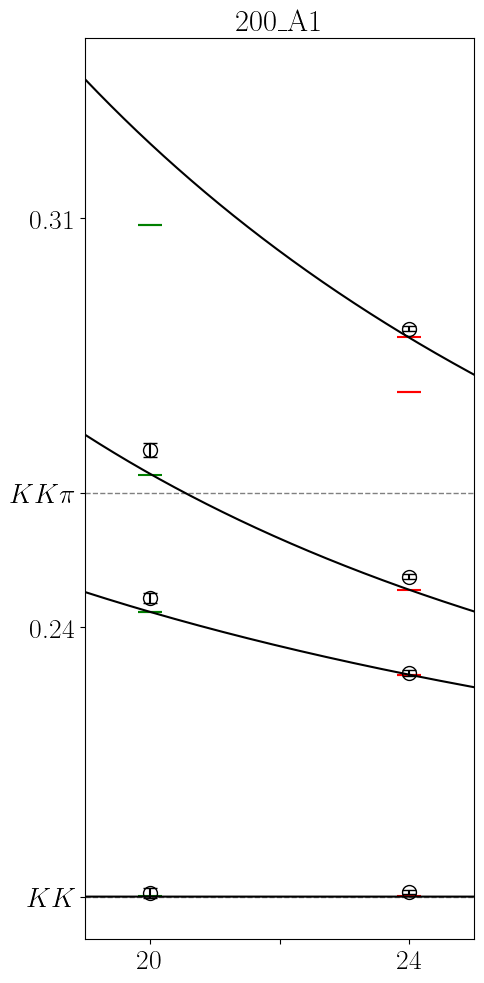

In [64]:
energy_file1 = "S2I1p_energies_L24"
energy_file2 = "S2I1p_energies_L20"

full_list, irrep_list = irrep_list_maker(energy_file1)
#nx,ny,nz = config_maker(4)
print(irrep_list)
atm = 0.09698
xi = 3.444
max_nsq = 4
Lmin = 19
Lmax = 25 
Lpoints = 2000 
full_energy_list, irrep_list = irrep_list_maker(energy_file1)

irrep = "200_A1"
discrete_nonint_spectrum_maker(atm, xi, max_nsq, irrep, Lmin, Lmax, Lpoints, energy_file1,energy_file2)
discrete_spectrum_plotter(irrep, energy_file1, energy_file2)